In [1]:
import os
import numpy as np
import cv2
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F

import torchvision
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from torchvision.io import decode_image
from torchvision.transforms import v2
from torchvision.transforms.functional import hflip
from PIL import Image, ImageFilter
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import wandb
from scipy.stats import gaussian_kde as kde
import matplotlib as mpl
from torchinfo import summary
import random
import math

In [2]:
# !rm -rf gitignored/face_emotion_recognition
# !mkdir gitignored/face_emotion_recognition
# !wget -O gitignored/face_emotion_recognition/FER_static_ResNet50_AffectNet.pt https://huggingface.co/ElenaRyumina/face_emotion_recognition/resolve/main/FER_static_ResNet50_AffectNet.pt?download=true

In [3]:
with open("gitignored/secrets/wandb") as f:
    wandb_secret = next(f).strip()

wandb.login(key=wandb_secret)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.


wandb: Appending key for api.wandb.ai to your netrc file: /home/ai_n_slo@lab.graphicon.ru/.netrc


wandb: Currently logged in as: nslobodchuk (other_) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [4]:
dataset_path = "/mnt/hdd/ai_n_slo/gazet-data-cropped"

In [5]:
metadata = pd.read_json(os.path.join(dataset_path, "metadata.json"))
image_sizes = pd.read_csv(os.path.join(dataset_path, "image_sizes.csv"), sep="\t", index_col=0)
print(metadata.shape)
metadata = pd.merge(metadata, image_sizes, on=["task_id", "step"])
print(metadata.shape)

(144275, 16)
(144275, 18)


## EDA

In [6]:
metadata.head()

,task_id,step,relative_x,relative_y,screen_size_x,screen_size_y,screen_size_cm_x,screen_size_cm_y,diagonal_cm,type,is_notebook,eyes_left_left,eyes_left_right,eyes_right_left,eyes_right_right,split,h,w
0,8f0ba296-96d9-4ff0-8de9-13cc0e2ae671,step_0.jpeg,0.0,0.0,1280,1024,33.73119,26.984952,43.197,gaze_on_fixed_point,False,"[632, 688]","[543, 698]","[434, 711]","[347, 722]",train,1080,1600
1,8f0ba296-96d9-4ff0-8de9-13cc0e2ae671,step_1.jpeg,1.0,0.0,1280,1024,33.73119,26.984952,43.197,gaze_on_fixed_point,False,"[574, 679]","[494, 684]","[395, 692]","[332, 699]",train,1080,1600
2,8f0ba296-96d9-4ff0-8de9-13cc0e2ae671,step_2.jpeg,0.0,1.0,1280,1024,33.73119,26.984952,43.197,gaze_on_fixed_point,False,"[669, 724]","[582, 733]","[475, 741]","[390, 746]",train,1080,1600
3,8f0ba296-96d9-4ff0-8de9-13cc0e2ae671,step_3.jpeg,1.0,1.0,1280,1024,33.73119,26.984952,43.197,gaze_on_fixed_point,False,"[592, 731]","[511, 739]","[416, 745]","[352, 747]",train,1080,1600
4,8f0ba296-96d9-4ff0-8de9-13cc0e2ae671,step_4.jpeg,0.5,0.5,1280,1024,33.73119,26.984952,43.197,gaze_on_fixed_point,False,"[622, 703]","[542, 711]","[444, 720]","[377, 728]",train,1080,1600


In [7]:
split_levels = metadata.split.unique()
type_levels = metadata.type.unique()

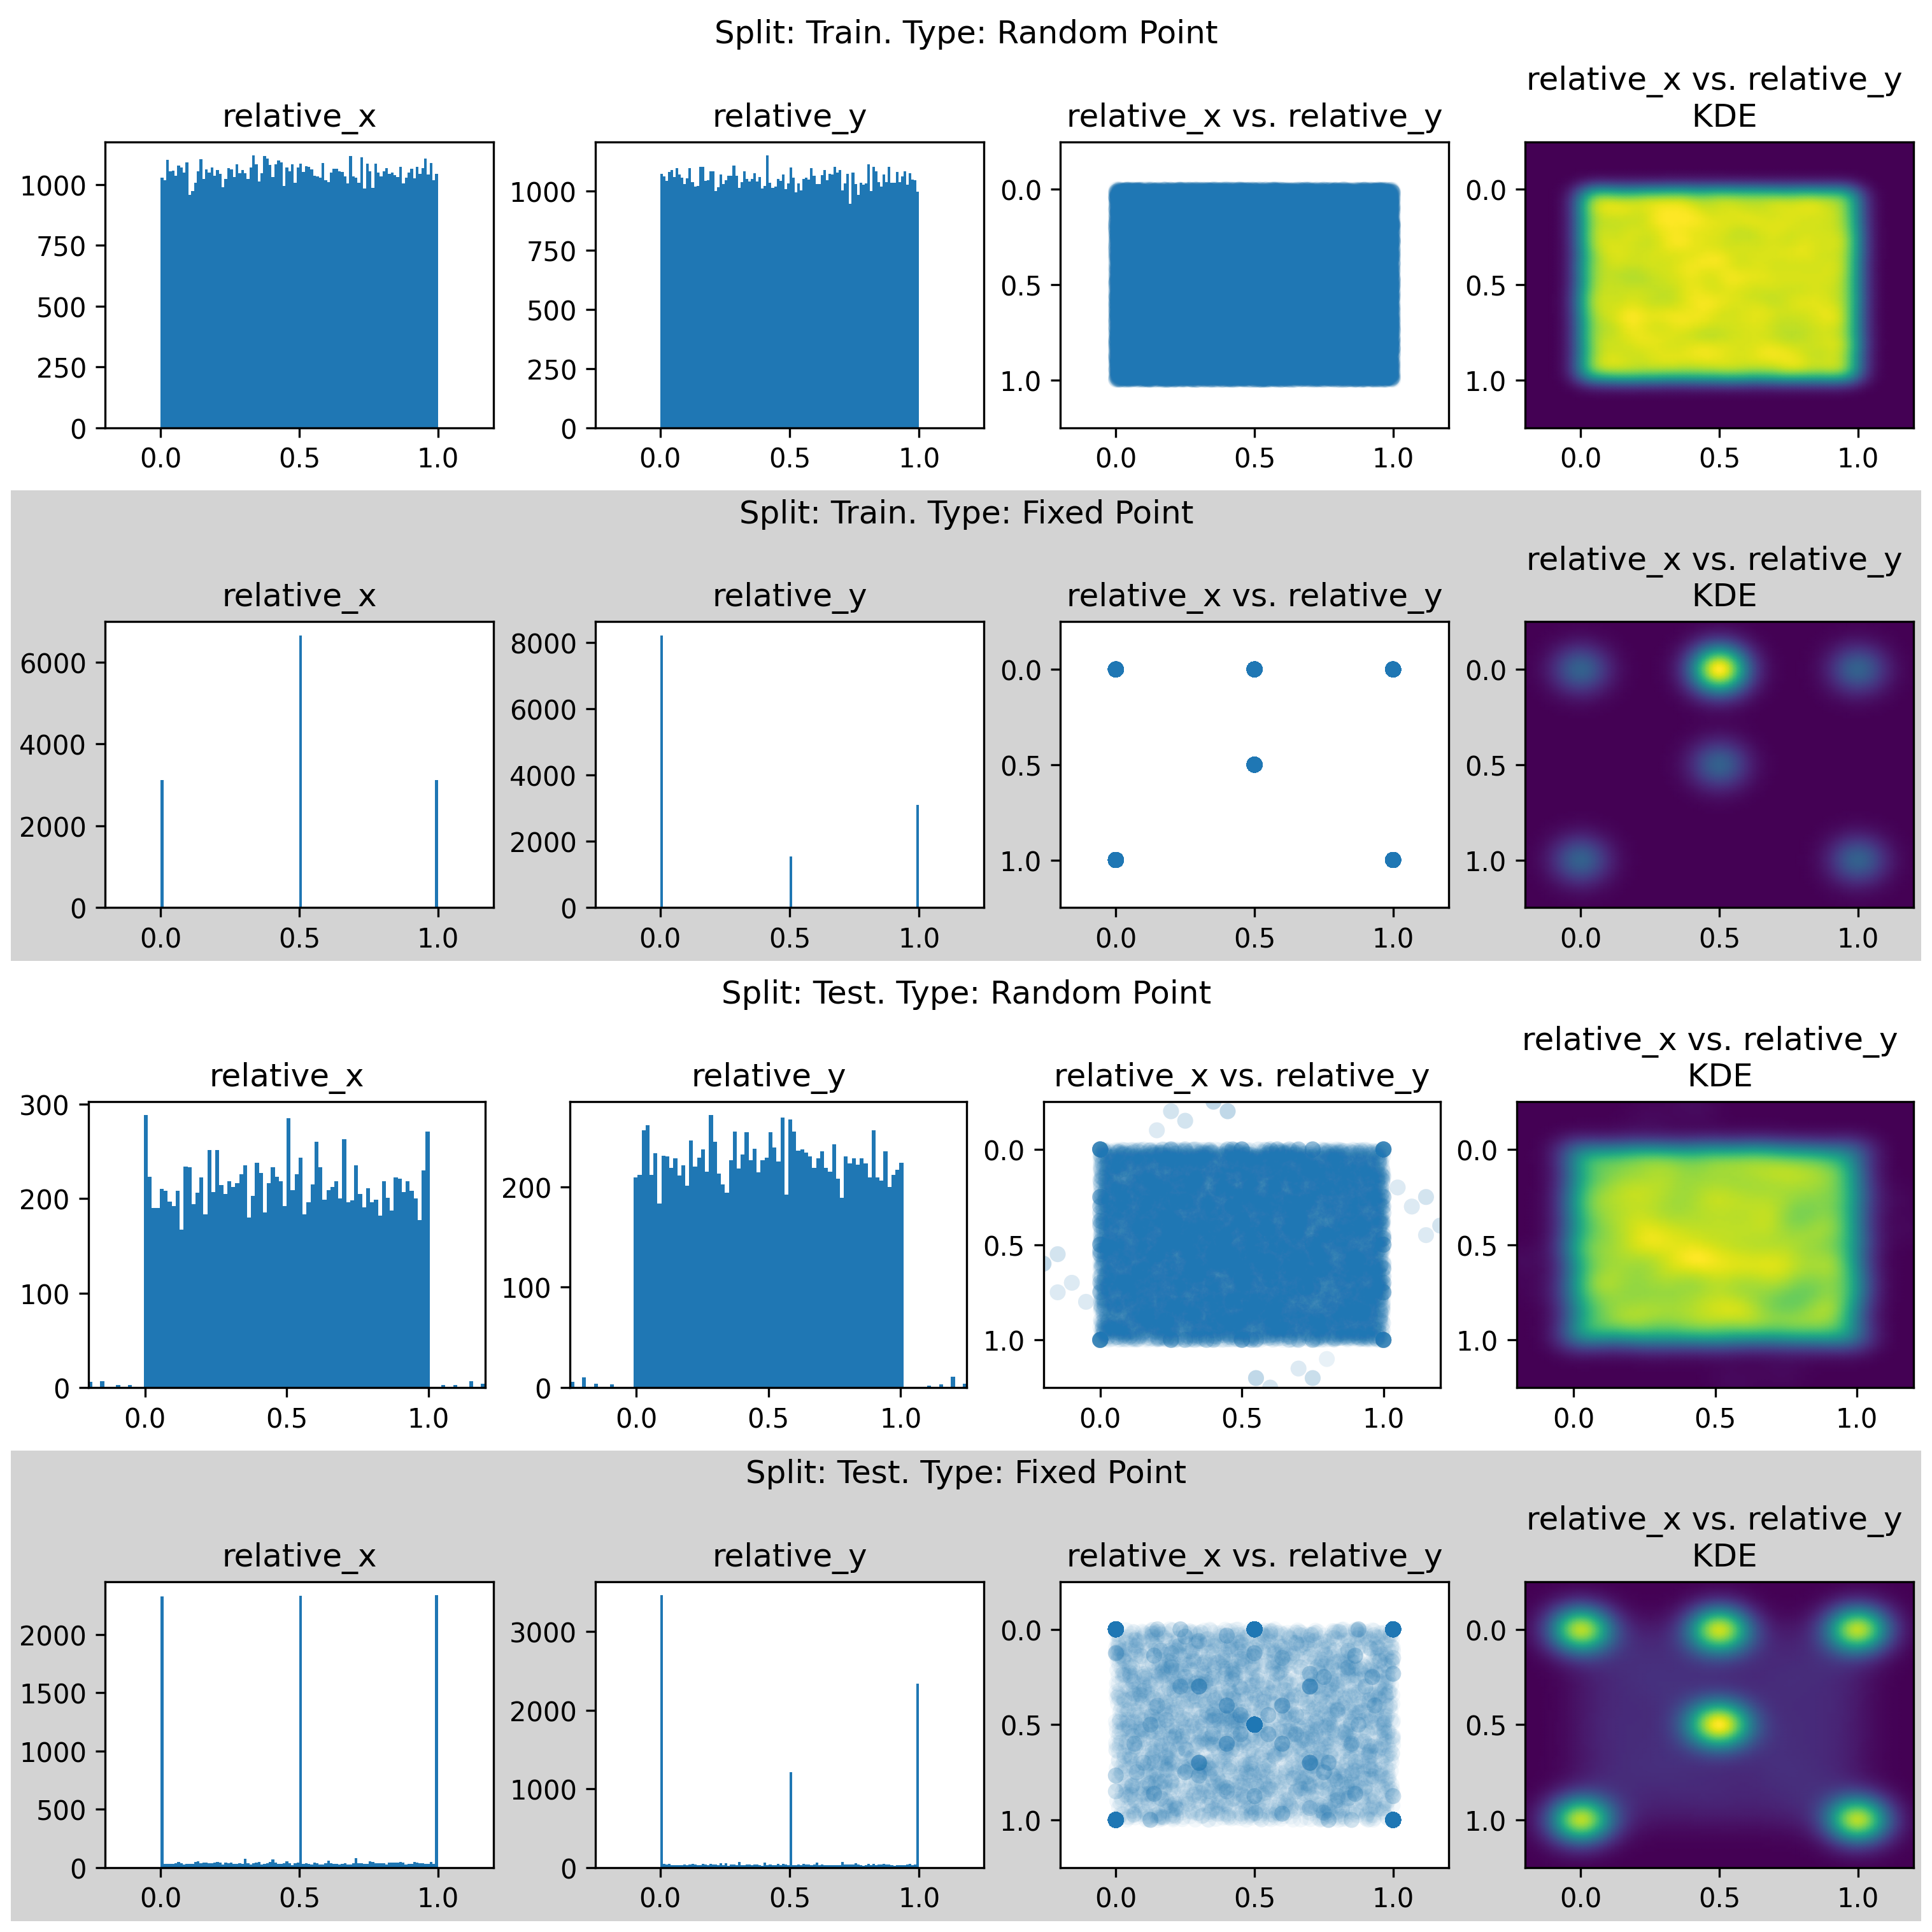

In [8]:
sf_titles = [
    "Split: Train. Type: Random Point",
    "Split: Train. Type: Fixed Point",
    "Split: Test. Type: Random Point",
    "Split: Test. Type: Fixed Point",
]

groups = [
    ("train", "gaze_on_random_point"),
    ("train", "gaze_on_fixed_point"),
    ("test", "gaze_on_random_point"),
    ("test", "gaze_on_fixed_point")
]


x_min, x_max = metadata.relative_x.min(), metadata.relative_x.max()
y_min, y_max = metadata.relative_y.min(), metadata.relative_y.max()

fig = plt.figure(layout='constrained', figsize=(10, 10), dpi=300)
subfigs = fig.subfigures(4, 1)
for sf_idx, sf in enumerate(subfigs):

    if sf_idx%2==1:
        sf.set_facecolor("lightgrey")

    split_, type_ = groups[sf_idx]
    metadata_subset = metadata[(metadata.split==split_)&(metadata.type==type_)]
    
    sf.suptitle(sf_titles[sf_idx])
    ax1, ax2, ax3, ax4 = sf.subplots(1,4)

    ax1.set_title("relative_x")
    ax1.hist(metadata_subset["relative_x"], bins=100)
    ax1.set_xlim(x_min, x_max)

    ax2.set_title("relative_y")
    ax2.hist(metadata_subset["relative_y"], bins=100)
    ax2.set_xlim(y_min, y_max)

    ax3.set_title("relative_x vs. relative_y")
    ax3.scatter(
        x=metadata_subset["relative_x"], 
        y=metadata_subset["relative_y"],
        alpha=0.05, 
        edgecolors="none"
    )
    ax3.set_xlim(x_min, x_max)
    ax3.set_ylim(y_max, y_min)

    x,y = metadata_subset[["relative_x", "relative_y"]].values.T
    
    nbins=100
    
    k = kde(np.array([x,y]))
    xi, yi = np.mgrid[x_min:x_max:nbins*1j, y_min:y_max:nbins*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))
    
    ax4.set_title("relative_x vs. relative_y \n KDE")
    ax4.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud')

    ax4.set_xlim(x_min, x_max)
    ax4.set_ylim(y_max, y_min)
    
plt.show()
# plt.savefig("./stats.png")

## Data Cleaning

In [9]:
# remove task_id if it has a point with relative_x or relative_y outside the [0,1] range

bad_metadata = metadata[
    (metadata.relative_x<0)|
    (metadata.relative_x>1)|
    (metadata.relative_y<0)|
    (metadata.relative_y>1)
]

print("Bad observations, #: ", len(bad_metadata))

bad_task_id = bad_metadata.task_id.unique()

print("Bad task_id's, #: ", len(bad_task_id))

print("metadata observations before cleaning ", len(metadata))
metadata = metadata[~metadata.task_id.isin(bad_task_id)]
print("metadata observations after cleaning ", len(metadata))


Bad observations, #:  79
Bad task_id's, #:  25
metadata observations before cleaning  144275
metadata observations after cleaning  142951


## Create Test Sample

In [10]:
# select only task_id's with all 6 fixed_points present

metadata["point"] = list(zip(metadata["relative_x"], metadata["relative_y"]))
fixed_points = metadata[(metadata.split=="train")&(metadata.type=="gaze_on_fixed_point")]["point"].unique()
metadata["fixed_point"] = metadata["point"].astype("category").cat.set_categories(fixed_points)

point_counts = (
    metadata.groupby(by=["task_id", "fixed_point"], observed=False)[["step"]]
    .count().reset_index().rename(columns={"step": "point_count"})
)

point_counts["point_present"] = point_counts["point_count"]>0

point_counts_2 = (
    point_counts.groupby(by=["task_id"])[["point_present"]]
    .sum().reset_index().rename(columns={"point_present": "n_fixed_points"})
)

point_counts_2 = pd.merge(
    point_counts_2, 
    metadata[["task_id", "split"]].groupby(["task_id"]).first().reset_index(),
    on="task_id"
)

test_task_id = (
    point_counts_2[
    (point_counts_2.split=="test")&
    (point_counts_2.n_fixed_points>=6)
    ]
    ["task_id"].unique()
)

metadata_train = metadata[metadata.split=="train"].reset_index(drop=True)
metadata_test_full = metadata[metadata.split=="test"].reset_index(drop=True)

metadata_calibration = metadata[
    (metadata.split=="test")&
    metadata.task_id.isin(test_task_id)&
    metadata.point.isin(fixed_points)
].reset_index(drop=True)

metadata_test = metadata[
    (metadata.split=="test")&
    (metadata.task_id.isin(test_task_id))&
    (~metadata.point.isin(fixed_points))
].reset_index(drop=True)

print("Train task_id's, #: ", metadata_train.task_id.nunique())
print("Train observations, #: ", metadata_train.shape[0])

print("Calibration task_id's, #: ", metadata_calibration.task_id.nunique())
print("Calibration observations, #: ", metadata_calibration.shape[0])

print("Test task_id's, #: ", metadata_test.task_id.nunique())
print("Test observations, #: ", metadata_test.shape[0])

calibration_points = metadata_calibration.point.unique()
print("Calibration points: ", calibration_points)

print("Test observations with point equal to calibrations point, #: ", 
      metadata_test[
          metadata_test.point.isin(calibration_points)
      ].shape[0]
     )



Train task_id's, #:  5583
Train observations, #:  118123
Calibration task_id's, #:  1107
Calibration observations, #:  6642
Test task_id's, #:  1107
Test observations, #:  17619
Calibration points:  [(0.0, 0.0) (1.0, 0.0) (0.0, 1.0) (1.0, 1.0) (0.5, 0.5) (0.5, 0.0)]
Test observations with point equal to calibrations point, #:  0


In [11]:
metadata_calibration

,task_id,step,relative_x,relative_y,screen_size_x,screen_size_y,screen_size_cm_x,screen_size_cm_y,diagonal_cm,type,is_notebook,eyes_left_left,eyes_left_right,eyes_right_left,eyes_right_right,split,h,w,point,fixed_point
0,67740288-d340-4987-8183-8f1fca4b5967,step_0.jpeg,0.0,0.0,1920,1080,34.105622,19.184413,39.131,gaze_on_fixed_point,True,"[392, 235]","[341, 238]","[281, 240]","[230, 241]",test,480,640,"(0.0, 0.0)","(0.0, 0.0)"
1,67740288-d340-4987-8183-8f1fca4b5967,step_1.jpeg,1.0,0.0,1920,1080,34.105622,19.184413,39.131,gaze_on_fixed_point,True,"[390, 240]","[338, 242]","[278, 244]","[227, 244]",test,480,640,"(1.0, 0.0)","(1.0, 0.0)"
2,67740288-d340-4987-8183-8f1fca4b5967,step_2.jpeg,0.0,1.0,1920,1080,34.105622,19.184413,39.131,gaze_on_fixed_point,True,"[392, 243]","[341, 246]","[282, 248]","[232, 248]",test,480,640,"(0.0, 1.0)","(0.0, 1.0)"
3,67740288-d340-4987-8183-8f1fca4b5967,step_3.jpeg,1.0,1.0,1920,1080,34.105622,19.184413,39.131,gaze_on_fixed_point,True,"[390, 246]","[338, 249]","[278, 252]","[227, 252]",test,480,640,"(1.0, 1.0)","(1.0, 1.0)"
4,67740288-d340-4987-8183-8f1fca4b5967,step_4.jpeg,0.5,0.5,1920,1080,34.105622,19.184413,39.131,gaze_on_fixed_point,True,"[393, 248]","[342, 250]","[282, 252]","[232, 252]",test,480,640,"(0.5, 0.5)","(0.5, 0.5)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6637,f1906375-bf2e-45c5-a5c6-16473a478f03,step_1.jpeg,1.0,0.0,1920,1080,34.105622,19.184413,39.131,gaze_on_fixed_point,True,"[709, 474]","[660, 478]","[604, 478]","[559, 474]",test,720,1280,"(1.0, 0.0)","(1.0, 0.0)"
6638,f1906375-bf2e-45c5-a5c6-16473a478f03,step_2.jpeg,0.0,1.0,1920,1080,34.105622,19.184413,39.131,gaze_on_fixed_point,True,"[762, 483]","[715, 488]","[654, 489]","[604, 486]",test,720,1280,"(0.0, 1.0)","(0.0, 1.0)"
6639,f1906375-bf2e-45c5-a5c6-16473a478f03,step_3.jpeg,1.0,1.0,1920,1080,34.105622,19.184413,39.131,gaze_on_fixed_point,True,"[701, 484]","[651, 488]","[593, 487]","[551, 482]",test,720,1280,"(1.0, 1.0)","(1.0, 1.0)"
6640,f1906375-bf2e-45c5-a5c6-16473a478f03,step_4.jpeg,0.5,0.5,1920,1080,34.105622,19.184413,39.131,gaze_on_fixed_point,True,"[734, 489]","[684, 493]","[624, 491]","[577, 485]",test,720,1280,"(0.5, 0.5)","(0.5, 0.5)"


In [12]:
to_expand = ["eyes_left_left", "eyes_left_right", "eyes_right_left", "eyes_right_right"]
        
for col in to_expand:
    metadata_train[[col+"_x", col+"_y"]] = metadata_train[col].to_list()


<Axes: >

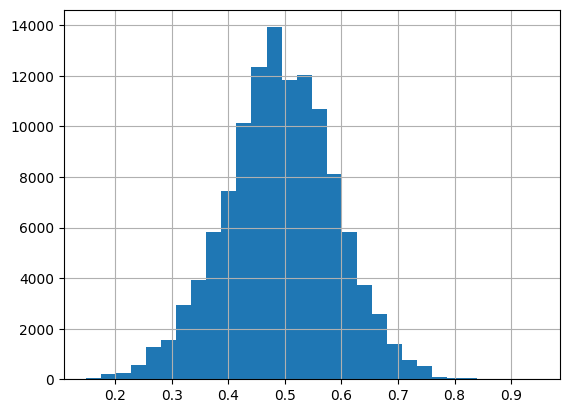

In [13]:
(metadata_train["eyes_left_left_y"]/metadata_train["h"]).hist(bins=30)

## Data Loader

In [14]:
class GazeT(Dataset):
    def __init__(self, metadata, data_dir=dataset_path, transform=None, target_transform=None, regularization_transforms=False):

        metadata = metadata.copy(deep=True)
        
        to_expand = ["eyes_left_left", "eyes_left_right", "eyes_right_left", "eyes_right_right"]
        
        for col in to_expand:
            metadata[[col+"_x", col+"_y"]] = metadata[col].to_list()
            metadata[col+"_x"] = metadata[col+"_x"]/metadata["w"]
            metadata[col+"_y"] = metadata[col+"_y"]/metadata["h"]
            
        self.metadata = metadata.drop(columns=to_expand)
        self.data_dir = data_dir
        self.transform = transform
        self.target_transform = target_transform
        self.regularization_transforms = regularization_transforms
        self.image_ratio = 2 #width/height
        self.resize_height = 224
        self.resize_width = self.resize_height*self.image_ratio
        
    def __len__(self):
        return self.metadata.shape[0]

    def __getitem__(self, idx):
        
        # label_x = self.metadata.iloc[idx, :]["relative_x"]*self.metadata.iloc[idx, :]["screen_size_cm_x"]
        # label_y = self.metadata.iloc[idx, :]["relative_y"]*self.metadata.iloc[idx, :]["screen_size_cm_y"]
        label_x = self.metadata.iloc[idx, :]["relative_x"]
        label_y = self.metadata.iloc[idx, :]["relative_y"]

        eyes_coordinates = []

        for dim in ["_x", "_y"]:
            for col in ["eyes_left_left", "eyes_left_right", "eyes_right_left", "eyes_right_right"]:
                eyes_coordinates.append(self.metadata.iloc[idx, :][col+dim])

        eyes_coordinates = np.array(eyes_coordinates)
        
        screen_size_x = self.metadata.iloc[idx, :]["screen_size_cm_x"]
        screen_size_y = self.metadata.iloc[idx, :]["screen_size_cm_y"]
        
        label = np.array([label_x, label_y])
        screen_size = np.array([screen_size_x, screen_size_y])
        
        task_id = self.metadata.iloc[idx, :]["task_id"]

        img_path = os.path.join(
            self.data_dir, "images/",
            task_id, self.metadata.iloc[idx, :]["step"]
        )
        image = decode_image(img_path)

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        # Pad images to the same proportion self.image_ratio
        h = image.shape[1]
        w = image.shape[2]

        if w/h<=self.image_ratio:
            padding = h*self.image_ratio - w
            padding_left = round(padding/2)
            padding_right = padding - padding_left
            image = v2.Pad(padding=[padding_left,0,padding_right,0])(image)
            image = v2.Resize(size=self.resize_height, interpolation = transforms.InterpolationMode.NEAREST)(image)
        else:
            image = v2.Resize(size = None, max_size=self.resize_width, interpolation = transforms.InterpolationMode.NEAREST)(image)
            padding = self.resize_height - image.shape[1]
            padding_top = round(padding/2)
            
            padding_bottom = padding - padding_top
            image = v2.Pad(padding=[0,padding_top,0,padding_bottom])(image)

        # if h>w:
        #     padding_left = round((h - w)/2)
        #     padding_right = h - w - padding_left
        #     image = v2.Pad(padding=[padding_left,0,padding_right,0])(image)
              
        # else:
        #     padding_top = round((w-h)/2)
        #     padding_bottom = w - h - padding_top
        #     image = v2.Pad(padding=[0,padding_top,0,padding_bottom])(image)
        
        # image = v2.Resize(size=(self.resize_height, self.resize_width))(image)
        # assert image.shape[1] == self.resize_height and image.shape[2] == self.resize_width

        # Resize padded images to (self.resize_width,self.resize_width) for NN
        # image = v2.Resize(size=(self.resize_width, self.resize_width))(image)
        # image = v2.Resize(size=(224, 224))(image)
        # image = v2.Resize(size=128)(image)
        # image = v2.Resize(size=(208, 208))(image)

        # image = v2.Pad(padding=[16,16,16,16])(image)

        if self.regularization_transforms:
            if random.randint(0, 1)==1:
                image = hflip(image)
                label[0] = 1-label[0]
                eyes_coordinates[:4] = 1 - eyes_coordinates[:4]
                
        transforms_ = v2.Compose([
                # v2.ToDtype(torch.float32, scale=True),
                v2.ToDtype(torch.float32, scale=False),
                # fixed_image_standardization
                # v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                v2.Normalize(mean=[91.4953, 103.8827, 131.0912], std=[1, 1, 1]),
            ])

        image = transforms_(image)
        
        return image, label, screen_size, task_id, torch.tensor(eyes_coordinates, dtype=torch.float32)

In [15]:
data_train = GazeT(metadata_train, regularization_transforms=True)
data_test = GazeT(metadata_test)
data_calibration = GazeT(metadata_calibration)
data_test_full = GazeT(metadata_test_full)
                 
dataloader_train = DataLoader(data_train, batch_size=96, shuffle=True)
dataloader_test = DataLoader(data_test, batch_size=96, shuffle=False)
dataloader_calibration = DataLoader(data_calibration, batch_size=96, shuffle=False)
dataloader_test_full = DataLoader(data_test_full, batch_size=96, shuffle=False)

In [16]:
# import matplotlib.pyplot as plt
# import torch
# from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
# from torchvision import tv_tensors
# from torchvision.transforms.v2 import functional as F


# def plot(imgs, row_title=None, **imshow_kwargs):
#     if not isinstance(imgs[0], list):
#         # Make a 2d grid even if there's just 1 row
#         imgs = [imgs]

#     num_rows = len(imgs)
#     num_cols = len(imgs[0])
#     _, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
#     for row_idx, row in enumerate(imgs):
#         for col_idx, img in enumerate(row):
#             boxes = None
#             masks = None
#             if isinstance(img, tuple):
#                 img, target = img
#                 if isinstance(target, dict):
#                     boxes = target.get("boxes")
#                     masks = target.get("masks")
#                 elif isinstance(target, tv_tensors.BoundingBoxes):
#                     boxes = target
#                 else:
#                     raise ValueError(f"Unexpected target type: {type(target)}")
#             img = F.to_image(img)
#             if img.dtype.is_floating_point and img.min() < 0:
#                 # Poor man's re-normalization for the colors to be OK-ish. This
#                 # is useful for images coming out of Normalize()
#                 img -= img.min()
#                 img /= img.max()

#             img = F.to_dtype(img, torch.uint8, scale=True)
#             if boxes is not None:
#                 img = draw_bounding_boxes(img, boxes, colors="yellow", width=3)
#             if masks is not None:
#                 img = draw_segmentation_masks(img, masks.to(torch.bool), colors=["green"] * masks.shape[0], alpha=.65)

#             ax = axs[row_idx, col_idx]
#             ax.imshow(img.permute(1, 2, 0).numpy(), **imshow_kwargs)
#             ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

#     if row_title is not None:
#         for row_idx in range(num_rows):
#             axs[row_idx, 0].set(ylabel=row_title[row_idx])

#     plt.tight_layout()

In [17]:
# train_features, train_labels, screen_size, task_id = next(iter(dataloader_train))
# print(f"Feature batch shape: {train_features.size()}")
# print(f"Labels batch shape: {train_labels.size()}")
# img = train_features[0].squeeze()
# label = train_labels[0]
# # plt.imshow(img.permute(1,2,0).int())
# # plt.show()
# plot([img])
# print(f"Label: {label}")

In [18]:
train_features, train_labels, screen_size, task_id, eyes_coordinates = next(iter(dataloader_train))

In [19]:
eyes_coordinates.dtype

torch.float32

In [20]:
eyes_coordinates.shape

torch.Size([96, 8])

## Neural Network

https://github.com/ElenaRyumina/EMO-AffectNetModel/tree/main

In [21]:
class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Bottleneck, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, padding=0, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(out_channels, eps=0.001, momentum=0.99)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding='same', bias=False)
        self.batch_norm2 = nn.BatchNorm2d(out_channels, eps=0.001, momentum=0.99)
        
        self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0, bias=False)
        self.batch_norm3 = nn.BatchNorm2d(out_channels*self.expansion, eps=0.001, momentum=0.99)
        
        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()
        
    def forward(self, x):
        identity = x.clone()
        x = self.relu(self.batch_norm1(self.conv1(x)))
        
        x = self.relu(self.batch_norm2(self.conv2(x)))
        
        x = self.conv3(x)
        x = self.batch_norm3(x)
        
        #downsample if needed
        if self.i_downsample is not None:
            identity = self.i_downsample(identity)
        #add identity
        x+=identity
        x=self.relu(x)
        
        return x

class Conv2dSame(torch.nn.Conv2d):

    def calc_same_pad(self, i: int, k: int, s: int, d: int) -> int:
        return max((math.ceil(i / s) - 1) * s + (k - 1) * d + 1 - i, 0)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        ih, iw = x.size()[-2:]

        pad_h = self.calc_same_pad(i=ih, k=self.kernel_size[0], s=self.stride[0], d=self.dilation[0])
        pad_w = self.calc_same_pad(i=iw, k=self.kernel_size[1], s=self.stride[1], d=self.dilation[1])

        if pad_h > 0 or pad_w > 0:
            x = F.pad(
                x, [pad_w // 2, pad_w - pad_w // 2, pad_h // 2, pad_h - pad_h // 2]
            )
        return F.conv2d(
            x,
            self.weight,
            self.bias,
            self.stride,
            self.padding,
            self.dilation,
            self.groups,
        )

class ResNet(nn.Module):
    def __init__(self, ResBlock, layer_list, num_classes, num_channels=3):
        super(ResNet, self).__init__()
        self.in_channels = 64

        self.conv_layer_s2_same = Conv2dSame(num_channels, 64, 7, stride=2, groups=1, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(64, eps=0.001, momentum=0.99)
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size = 3, stride=2)
        
        self.layer1 = self._make_layer(ResBlock, layer_list[0], planes=64, stride=1)
        self.layer2 = self._make_layer(ResBlock, layer_list[1], planes=128, stride=2)
        self.layer3 = self._make_layer(ResBlock, layer_list[2], planes=256, stride=2)
        self.layer4 = self._make_layer(ResBlock, layer_list[3], planes=512, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc1 = nn.Linear(512*ResBlock.expansion, 512)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(512, num_classes)

    def extract_features(self, x):
        x = self.relu(self.batch_norm1(self.conv_layer_s2_same(x)))
        x = self.max_pool(x)
        # print(x.shape)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc1(x)
        return x
        
    def forward(self, x):
        x = self.extract_features(x)
        x = self.relu1(x)
        x = self.fc2(x)
        return x
        
    def _make_layer(self, ResBlock, blocks, planes, stride=1):
        ii_downsample = None
        layers = []
        
        if stride != 1 or self.in_channels != planes*ResBlock.expansion:
            ii_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, planes*ResBlock.expansion, kernel_size=1, stride=stride, bias=False, padding=0),
                nn.BatchNorm2d(planes*ResBlock.expansion, eps=0.001, momentum=0.99)
            )
            
        layers.append(ResBlock(self.in_channels, planes, i_downsample=ii_downsample, stride=stride))
        self.in_channels = planes*ResBlock.expansion
        
        for i in range(blocks-1):
            layers.append(ResBlock(self.in_channels, planes))
            
        return nn.Sequential(*layers)
        
def ResNet50(num_classes, channels=3):
    return ResNet(Bottleneck, [3,4,6,3], num_classes, channels)

In [22]:
pth_backbone_model = ResNet50(7, channels=3)
pth_backbone_model.load_state_dict(
    torch.load('gitignored/face_emotion_recognition/FER_static_ResNet50_AffectNet.pt')
)

<All keys matched successfully>

In [23]:
class NeuralNetwork(nn.Module):
    def __init__(self, model, use_eyes=True):
        super().__init__()

        self.use_eyes = use_eyes
        model.fc2 = nn.Identity()
        self.model = model

        self.eyes_model = nn.Sequential(
            # nn.Dropout(p=0.5),
            nn.Linear(8,512),
            nn.GELU(),
        )

        if self.use_eyes:
            self.head_stack = nn.Sequential(
                # nn.Dropout(p=0.5),
                nn.Linear(512+512,512),
                nn.GELU(),
                # nn.Dropout(p=0.5),
                nn.Linear(512,512),
                nn.GELU(),
                # nn.Dropout(p=0.5),
                nn.Linear(512, 2), 
            )
        else:
            self.head_stack = nn.Sequential(
                nn.Dropout(p=0.5),
                nn.Linear(512, 2),
            )
        
        for layer in self.head_stack:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                nn.init.zeros_(layer.bias)

        for layer in self.eyes_model:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                nn.init.zeros_(layer.bias)

    def forward(self, x, eyes_coordinates, clamp_eval=True):
        preds = self.model(x)
        if self.use_eyes:
            eyes_preds = self.eyes_model(eyes_coordinates)
            preds = self.head_stack(torch.cat((preds, eyes_preds), 1))
        else:
            preds = self.head_stack(preds)
            
        if not self.training and clamp_eval:
            preds = torch.clamp(preds, min=0, max=1)
        return preds

In [24]:
import time

def train(net, train_dataloader, valid_dataloader, criterion, 
          optimizer, scheduler=None, epochs=10, device='cpu', checkpoint_epochs=10):
    
    start = time.time()
    print(f'Training for {epochs} epochs on {device}')
    
    for epoch in range(1,epochs+1):
        print(f"Epoch {epoch}/{epochs}")
        
        net.train()  # put network in train mode for Dropout and Batch Normalization
        train_loss = torch.tensor(0., device=device)  # loss and accuracy tensors are on the GPU to avoid data transfers
        train_loss_cm = torch.tensor(0., device=device)
        for X, y, screen_size, task_id, eyes_coordinates in train_dataloader:
            X = X.to(device)
            eyes_coordinates = eyes_coordinates.to(device)
            y = y.to(device)
            screen_size = screen_size.to(device)
            preds = net(X, eyes_coordinates)
            
            loss = criterion(preds, y).mean()
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            with torch.no_grad():
                train_loss += loss * train_dataloader.batch_size
                
                loss_cm = criterion(preds*screen_size, y*screen_size).mean()
                train_loss_cm += loss_cm * train_dataloader.batch_size
                
        
        if valid_dataloader is not None:
            net.eval()
            valid_loss = torch.tensor(0., device=device)
            valid_loss_cm = torch.tensor(0., device=device)
            with torch.no_grad():
                for X, y, screen_size, task_id, eyes_coordinates in valid_dataloader:

                    X = X.to(device)
                    eyes_coordinates = eyes_coordinates.to(device)
                    y = y.to(device)
                    screen_size = screen_size.to(device)
                    
                    preds = net(X, eyes_coordinates)
                    
                    loss = criterion(preds, y).mean()
                    loss_cm = criterion(preds*screen_size, y*screen_size).mean()
                    
                    valid_loss += loss * valid_dataloader.batch_size
                    valid_loss_cm += loss_cm * valid_dataloader.batch_size

        
        if scheduler is not None: 
            scheduler.step()
            
        print(f'Train loss, (mean relative distance): {train_loss/len(train_dataloader.dataset):.2f}')
        print(f'Train loss, (mean distance in cm): {train_loss_cm/len(train_dataloader.dataset):.2f}')
        wandb.log({"train_loss_relative": train_loss/len(train_dataloader.dataset)})
        wandb.log({"train_loss_cm": train_loss_cm/len(train_dataloader.dataset)})
        
        if valid_dataloader is not None:
            print(f'Valid loss, (mean relative distance): {valid_loss/len(valid_dataloader.dataset):.2f}')
            print(f'Valid loss, (mean distance in cm): {valid_loss_cm/len(valid_dataloader.dataset):.2f}')
            wandb.log({"valid_loss_relative": valid_loss/len(valid_dataloader.dataset)})
            wandb.log({"valid_loss_cm": valid_loss_cm/len(valid_dataloader.dataset)})
        
        if epoch%checkpoint_epochs==0 or epoch==epochs:
            torch.save({
                'epoch': epoch,
                'state_dict': net.state_dict(),
                'optimizer': optimizer.state_dict(),
            }, './gitignored/checkpoint.pth.tar')
        
        print()
    
    end = time.time()
    print(f'Total training time: {end-start:.1f} seconds')
    return net

In [25]:
# device = 'cuda' if torch.cuda.is_available() else 'cpu'

# CONFIG = {
#     "lr": 1e-5,
#     "weight_decay": 5e-4
# }

# epochs = 20

# net = get_net().to(device)

# criterion = torch.nn.PairwiseDistance(p=2)

# params_1x = [param for name, param in net.named_parameters() if 'fc' not in str(name)]
# optimizer = torch.optim.Adam([
#     {'params':params_1x}, 
#     {'params': net.fc.parameters(), 'lr': CONFIG["lr"]*10}
# ], **CONFIG)

In [26]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

CONFIG = {
    "lr": 1e-5,
    "weight_decay": 5e-4
}

epochs = 20

net = NeuralNetwork(pth_backbone_model, use_eyes=True).to(device)

params_1x = [param for name, param in net.model.named_parameters() 
             if "fc2" not in name 
             and "eyes_model" not in name 
             and "head_stack" not in name
            ]
params_2x = list(net.head_stack.parameters()) + list(net.eyes_model.parameters())

criterion = torch.nn.PairwiseDistance(p=2)

optimizer = torch.optim.Adam([
    {'params':params_1x}, 
    {'params': params_2x, 'lr': CONFIG["lr"]*10}
], **CONFIG)

In [27]:
summary(net, input_size=[(64,3, 224, 224*2), (64,8)], col_names=["input_size", "output_size", "num_params"])

Layer (type:depth-idx)                        Input Shape               Output Shape              Param #
NeuralNetwork                                 [64, 3, 224, 448]         [64, 2]                   --
├─ResNet: 1-1                                 [64, 3, 224, 448]         [64, 512]                 --
│    └─Conv2dSame: 2-1                        [64, 3, 224, 448]         [64, 64, 112, 224]        9,408
│    └─BatchNorm2d: 2-2                       [64, 64, 112, 224]        [64, 64, 112, 224]        128
│    └─ReLU: 2-3                              [64, 64, 112, 224]        [64, 64, 112, 224]        --
│    └─MaxPool2d: 2-4                         [64, 64, 112, 224]        [64, 64, 55, 111]         --
│    └─Sequential: 2-5                        [64, 64, 55, 111]         [64, 256, 55, 111]        --
│    │    └─Bottleneck: 3-1                   [64, 64, 55, 111]         [64, 256, 55, 111]        75,008
│    │    └─Bottleneck: 3-2                   [64, 256, 55, 111]        [64, 2

In [28]:
# resnet = torchvision.models.resnet50()
# summary(resnet, input_size=(128, 3, 160, 160), col_names=["input_size", "output_size", "num_params"])

In [29]:
run = wandb.init(project='gaze-t', 
                 config=CONFIG,
                 group='resnet18', 
                 job_type='train') # Note the job_type

wandb.config.type = 'baseline'
wandb.watch(net, log_freq=100)

wandb: Tracking run with wandb version 0.19.10


wandb: Run data is saved locally in /mnt/hd1/ai_n_slo/gaze-estimation/wandb/run-20250424_201253-0ow4t91d
wandb: Run `wandb offline` to turn off syncing.


wandb: Syncing run golden-aardvark-71


wandb: ⭐️ View project at https://wandb.ai/other_/gaze-t


wandb: 🚀 View run at https://wandb.ai/other_/gaze-t/runs/0ow4t91d


In [30]:
net = train(net, dataloader_train, dataloader_test_full,
            criterion, optimizer, None, epochs, device)

run.finish()

Training for 20 epochs on cuda
Epoch 1/20


Train loss, (mean relative distance): 0.24
Train loss, (mean distance in cm): 6.50
Valid loss, (mean relative distance): 0.22
Valid loss, (mean distance in cm): 5.53

Epoch 2/20


Train loss, (mean relative distance): 0.18
Train loss, (mean distance in cm): 4.70
Valid loss, (mean relative distance): 0.18
Valid loss, (mean distance in cm): 4.77

Epoch 3/20


Train loss, (mean relative distance): 0.16
Train loss, (mean distance in cm): 4.20
Valid loss, (mean relative distance): 0.17
Valid loss, (mean distance in cm): 4.49

Epoch 4/20


Train loss, (mean relative distance): 0.14
Train loss, (mean distance in cm): 3.82
Valid loss, (mean relative distance): 0.17
Valid loss, (mean distance in cm): 4.33

Epoch 5/20


Train loss, (mean relative distance): 0.13
Train loss, (mean distance in cm): 3.54
Valid loss, (mean relative distance): 0.17
Valid loss, (mean distance in cm): 4.26

Epoch 6/20


Train loss, (mean relative distance): 0.12
Train loss, (mean distance in cm): 3.35
Valid loss, (mean relative distance): 0.17
Valid loss, (mean distance in cm): 4.26

Epoch 7/20


Train loss, (mean relative distance): 0.12
Train loss, (mean distance in cm): 3.15
Valid loss, (mean relative distance): 0.17
Valid loss, (mean distance in cm): 4.37

Epoch 8/20


Train loss, (mean relative distance): 0.11
Train loss, (mean distance in cm): 2.99
Valid loss, (mean relative distance): 0.16
Valid loss, (mean distance in cm): 4.18

Epoch 9/20


Train loss, (mean relative distance): 0.10
Train loss, (mean distance in cm): 2.85
Valid loss, (mean relative distance): 0.16
Valid loss, (mean distance in cm): 4.18

Epoch 10/20


Train loss, (mean relative distance): 0.10
Train loss, (mean distance in cm): 2.72
Valid loss, (mean relative distance): 0.17
Valid loss, (mean distance in cm): 4.26



Epoch 11/20


Train loss, (mean relative distance): 0.10
Train loss, (mean distance in cm): 2.62
Valid loss, (mean relative distance): 0.16
Valid loss, (mean distance in cm): 4.12

Epoch 12/20


Train loss, (mean relative distance): 0.09
Train loss, (mean distance in cm): 2.52
Valid loss, (mean relative distance): 0.16
Valid loss, (mean distance in cm): 4.17

Epoch 13/20


Train loss, (mean relative distance): 0.09
Train loss, (mean distance in cm): 2.44
Valid loss, (mean relative distance): 0.16
Valid loss, (mean distance in cm): 4.13

Epoch 14/20


Train loss, (mean relative distance): 0.09
Train loss, (mean distance in cm): 2.36
Valid loss, (mean relative distance): 0.16
Valid loss, (mean distance in cm): 4.27

Epoch 15/20


Train loss, (mean relative distance): 0.08
Train loss, (mean distance in cm): 2.29
Valid loss, (mean relative distance): 0.16
Valid loss, (mean distance in cm): 4.02

Epoch 16/20


Train loss, (mean relative distance): 0.08
Train loss, (mean distance in cm): 2.23
Valid loss, (mean relative distance): 0.16
Valid loss, (mean distance in cm): 4.09

Epoch 17/20


Train loss, (mean relative distance): 0.08
Train loss, (mean distance in cm): 2.18
Valid loss, (mean relative distance): 0.16
Valid loss, (mean distance in cm): 4.05

Epoch 18/20


Train loss, (mean relative distance): 0.08
Train loss, (mean distance in cm): 2.12
Valid loss, (mean relative distance): 0.16
Valid loss, (mean distance in cm): 4.12

Epoch 19/20


Train loss, (mean relative distance): 0.08
Train loss, (mean distance in cm): 2.09
Valid loss, (mean relative distance): 0.16
Valid loss, (mean distance in cm): 4.07

Epoch 20/20


Train loss, (mean relative distance): 0.07
Train loss, (mean distance in cm): 2.04
Valid loss, (mean relative distance): 0.16
Valid loss, (mean distance in cm): 4.02



Total training time: 18747.5 seconds


wandb: uploading wandb-summary.json; uploading config.yaml


wandb: uploading history steps 76-79, summary


wandb:                                                                                


wandb: 
wandb: Run history:
wandb:       train_loss_cm █▅▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁
wandb: train_loss_relative █▅▅▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁
wandb:       valid_loss_cm █▄▃▂▂▂▃▂▂▂▁▂▁▂▁▁▁▁▁▁
wandb: valid_loss_relative █▄▃▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁
wandb: 
wandb: Run summary:
wandb:       train_loss_cm 2.04246
wandb: train_loss_relative 0.07409
wandb:       valid_loss_cm 4.01734
wandb: valid_loss_relative 0.15817
wandb: 


wandb: 🚀 View run golden-aardvark-71 at: https://wandb.ai/other_/gaze-t/runs/0ow4t91d
wandb: ⭐️ View project at: https://wandb.ai/other_/gaze-t
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)


wandb: Find logs at: ./wandb/run-20250424_201253-0ow4t91d/logs


## Calibration

In [31]:
checkpoint = torch.load("./gitignored/checkpoint.pth.tar", weights_only=True)
net.load_state_dict(checkpoint["state_dict"])

<All keys matched successfully>

In [32]:
#calibration data

net.eval() 
task_id_list = []
y_list = []
preds_list = []
screen_size_list = []

with torch.no_grad():
    for X, y, screen_size, task_id, eyes_coordinates in dataloader_calibration:
        X = X.to(device)
        eyes_coordinates = eyes_coordinates.to(device)
        y = y.to(device)
        preds = net(X, eyes_coordinates, clamp_eval=False).cpu().detach().numpy()

        task_id_list+=task_id
        y_list+=[[d[0], d[1]] for d in y.cpu().detach().numpy()]
        preds_list+=[[d[0], d[1]] for d in preds]
        screen_size_list += [d for d in screen_size.cpu().detach().numpy()]

calibration_data = pd.DataFrame({
    "task_id": task_id_list,
    "x": [d[0] for d in y_list],
    "y": [d[1] for d in y_list],
    "x_hat": [d[0] for d in preds_list],
    "y_hat": [d[1] for d in preds_list],
    "screensize_x": [d[0] for d in screen_size_list],
    "screensize_y": [d[1] for d in screen_size_list],
    
})

In [33]:
# test data

net.eval() 
task_id_list = []
y_list = []
preds_list = []
screen_size_list = []

with torch.no_grad():
    for X, y, screen_size, task_id, eyes_coordinates in dataloader_test:
        X = X.to(device)
        eyes_coordinates = eyes_coordinates.to(device)
        y = y.to(device)
        preds = net(X, eyes_coordinates, clamp_eval=False).cpu().detach().numpy()

        task_id_list+=task_id
        y_list+=[[d[0], d[1]] for d in y.cpu().detach().numpy()]
        preds_list+=[[d[0], d[1]] for d in preds]
        screen_size_list += [d for d in screen_size.cpu().detach().numpy()]

test_data = pd.DataFrame({
    "task_id": task_id_list,
    "x": [d[0] for d in y_list],
    "y": [d[1] for d in y_list],
    "x_hat": [d[0] for d in preds_list],
    "y_hat": [d[1] for d in preds_list],
    "screensize_x": [d[0] for d in screen_size_list],
    "screensize_y": [d[1] for d in screen_size_list],
})

In [34]:
import cvxpy as cp

In [35]:
# %%timeit

task_ids = calibration_data.task_id.unique()
for task_id in task_ids:
    
    D = calibration_data[calibration_data.task_id==task_id]

    T = D[["x","y"]].values
    G = D[["x_hat", "y_hat"]].values
    n = D.shape[0]
    
    
    # M = cp.Variable((2,2), diag=True)
    # M = cp.Variable((2,2))
    # M = cp.Variable()
    v = cp.Variable((2,1))
    Z = cp.Variable((2,n))

    objective = cp.sum_squares(Z)
    # objective = cp.sum_squares(Z) + 0.5*cp.norm2(M) + 0.3*cp.norm2(v)
    # objective = cp.sum_squares(Z) + 0.4*cp.norm2(M)+ 0.4*cp.norm2(v)
    # objective = cp.sum_squares(Z) + 0.1*cp.norm2(v) + 0.1*cp.norm1(np.array([[1,0]]) @ v)+ 0.1*cp.norm1(np.array([[0,1]]) @ v)
    # objective = cp.sum_squares(Z) + 0.2*cp.norm2(v)+ 0.4*cp.norm2(M) + 0.01*cp.norm1(np.array([[1,0]]) @ M)+ 0.01*cp.norm1(np.array([[0,1]]) @ M) + 0.1*cp.norm1(np.array([[1,0]]) @ v)+ 0.1*cp.norm1(np.array([[0,1]]) @ v)
    
    # constraints = [
    #     v @ np.ones((1,n)) + M@G.T - T.T - Z == 0
    # ]
    
    constraints = [
        v @ np.ones((1,n)) + G.T - T.T - Z == 0
    ]
    
    
    objective = cp.Minimize(objective)
    problem = cp.Problem(objective,constraints)
    problem.solve()

    # predicts_calibrated = v.value @ np.ones((1,D.shape[0])) + M.value @ D[["x_hat", "y_hat"]].values.T
    # predicts_calibrated = v.value @ np.ones((1,D.shape[0])) + M.value * D[["x_hat", "y_hat"]].values.T
    predicts_calibrated = v.value @ np.ones((1,D.shape[0])) + D[["x_hat", "y_hat"]].values.T
    calibration_data.loc[
        calibration_data.task_id==task_id, 
        ["x_hat_calibrated", "y_hat_calibrated"]
    ] = predicts_calibrated.T

    D_test = test_data[test_data.task_id==task_id]
    # predicts_test_calibrated = v.value @ np.ones((1,D_test.shape[0])) + M.value @ D_test[["x_hat", "y_hat"]].values.T
    # predicts_test_calibrated = v.value @ np.ones((1,D_test.shape[0])) + M.value * D_test[["x_hat", "y_hat"]].values.T
    predicts_test_calibrated = v.value @ np.ones((1,D_test.shape[0])) + D_test[["x_hat", "y_hat"]].values.T
    test_data.loc[
        test_data.task_id==task_id, 
        ["x_hat_calibrated", "y_hat_calibrated"]
    ] = predicts_test_calibrated.T

test_data["x_hat_calibrated"] = np.clip(test_data["x_hat_calibrated"], a_min=0, a_max=1)
test_data["y_hat_calibrated"] = np.clip(test_data["y_hat_calibrated"], a_min=0, a_max=1)
    

<Axes: xlabel='x', ylabel='x_hat'>

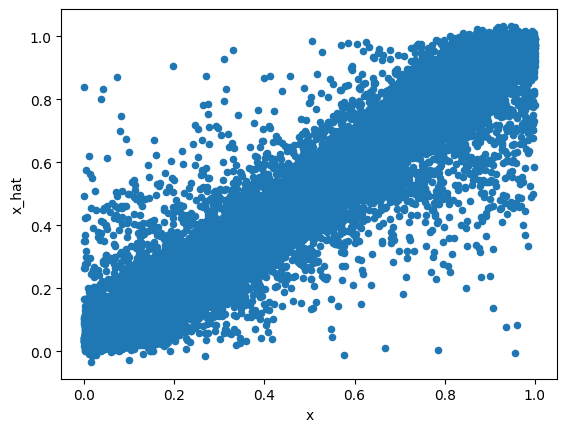

In [36]:
test_data.plot.scatter(x="x", y="x_hat")

<Axes: xlabel='x', ylabel='x_hat_calibrated'>

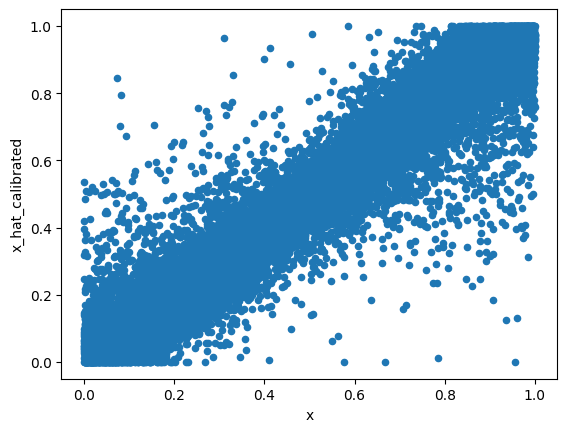

In [37]:
test_data.plot.scatter(x="x", y="x_hat_calibrated")

<Axes: xlabel='y', ylabel='y_hat'>

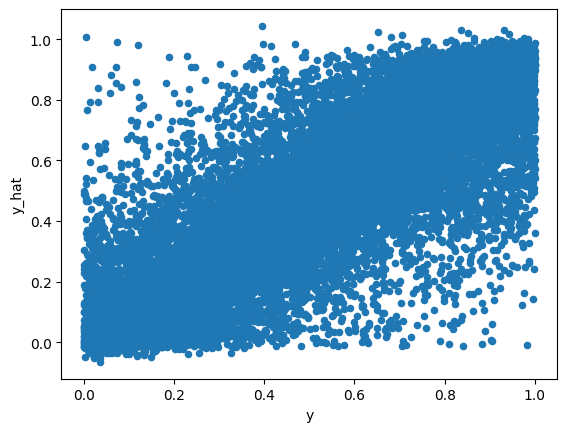

In [38]:
test_data.plot.scatter(x="y", y="y_hat")

<Axes: xlabel='y', ylabel='y_hat_calibrated'>

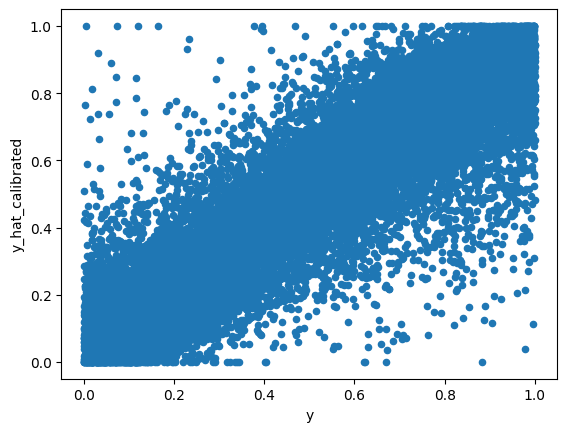

In [39]:
test_data.plot.scatter(x="y", y="y_hat_calibrated")

In [40]:
criterion = torch.nn.PairwiseDistance(p=2)

In [41]:
# X = X.to(device)
# y = y.to(device)

# preds = net(X)
criterion(
    torch.from_numpy(
        test_data[["x_hat_calibrated", "y_hat_calibrated"]].values*
        test_data[["screensize_x", "screensize_y"]].values
    ), 
    torch.from_numpy(
        test_data[["x", "y"]].values*
        test_data[["screensize_x", "screensize_y"]].values
    )
).mean()

tensor(3.5174, dtype=torch.float64)

In [42]:
criterion(
    torch.from_numpy(
        test_data[["x_hat", "y_hat"]].values*
        test_data[["screensize_x", "screensize_y"]].values
    ), 
    torch.from_numpy(
        test_data[["x", "y"]].values*
        test_data[["screensize_x", "screensize_y"]].values
    )
).mean()

tensor(4.0068, dtype=torch.float64)